In [1]:
import sys
sys.path.append('../src/')
import torch
from dataloaders.dataloader import get_floodnet_dataloader
from utils.transforms import *
import matplotlib.pyplot as plt
import pandas as pd
import string
import os
from PIL import Image
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

/home/s180366/raid/flooded-areas-ai-pytorch/.venv/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class_test_data = get_floodnet_dataloader(inputs_path="../dataset/FloodNet_dataset/test/image",
                                          targets_path="../dataset/flood_test_rel_paths.csv",
                                          transforms=[classification_image_tf],
                                          batch_size=1,
                                          shuffle=False)

In [2]:
seg_test_data = get_floodnet_dataloader(inputs_path="../dataset/FloodNet_dataset/test/image",
                                        targets_path="../dataset/FloodNet_dataset/test/label",
                                        transforms=[segmentation_image_tf, segmentation_mask_tf, seg_joint_transform],
                                        batch_size=1,
                                        shuffle=False)

In [ ]:
for X, y in class_test_data:
    print(X)
    print(y)
    break

In [ ]:
# classification
# folder = "class_aug_2"
# filenames = [
#     "classification_inceptionnetv3_bce.csv",
#     "classification_inceptionnetv3_dice.csv",
#     "classification_resnet50_bce.csv",
#     "classification_resnet50_dice.csv",
#     "classification_xception_bce.csv",
#     "classification_xception_dice.csv"
# ]
# model_names = [
#     "InceptionNetV3 BCE",
#     "InceptionNetV3 Dice",
#     "ResNet50 BCE",
#     "ResNet50 Dice",
#     "Xception BCE",
#     "Xception Dice"
# ]

# classification
folder = "seg_aug_2"
filenames = [
    "segmentation_deeplab_ce.csv",
    "segmentation_deeplab_dice.csv",
    "segmentation_pspnet_ce.csv",
    "segmentation_pspnet_dice.csv",
    "segmentation_enet_ce.csv",
    "segmentation_enet_dice.csv",
    "unet_unet3plus_ce.csv",
    "unet_unet3plus_dice.csv"
]
model_names = [
    "DeepLabV3 CE",
    "DeepLabV3 Dice",
    "PSPNet CE",
    "PSPNet Dice",
    "ENet CE",
    "ENet Dice",
    "UNet3+ CE",
    "UNet3+ Dice"
]

### Plot train and val loss

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()
labels = list(string.ascii_lowercase)
for i, f in enumerate(filenames):
    config_name = f.split("/")[-1].split(".")[0]
    train_loss_name = config_name + "_train_loss"
    val_loss_name = config_name + "_val_loss"

    df = pd.read_csv(os.path.join(folder, f))
    train_loss = df[train_loss_name].tolist()
    val_loss = df[val_loss_name].tolist()

    epochs = range(1, len(train_loss) + 1)

    ax = axes[i]
    ax.plot(epochs, train_loss, 'bo-', label='Strata treningowa')
    ax.plot(epochs, val_loss, 'ro-', label='Strata walidacyjna')
    ax.set_title(model_names[i])
    ax.set_xlabel('Epoka')
    ax.set_ylabel('Strata')
    ax.legend()
    ax.grid(True)

    ax.text(-0.05, 1.05, f"{labels[i]})", transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.suptitle("Wartości funkcji straty dla modeli segmentacji", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.98)
plt.savefig(os.path.join(folder, "losses.png"), dpi=300, bbox_inches='tight')
plt.show()


### Image and segmentation mask example

In [ ]:
img_number = "7320"
image_path = f"../dataset/FloodNet_dataset/test/image/{img_number}.jpg"
ground_truth_path = f"../dataset/FloodNet_dataset/test/label/{img_number}_lab.png"

# Define a colormap with 10 distinct colors
COLORMAP = [
    (0, 0, 0),        # class 0 - black
    (255, 0, 0),      # class 1 - maroon
    (181, 72, 72),      # class 2 - green
    (150, 150, 0),    # class 3 - olive
    (135, 135, 135),      # class 4 - navy
    (0, 224, 224),    # class 5 - purple
    (0, 100, 0),    # class 6 - teal
    (204, 0, 204),  # class 7 - gray
    (237, 237, 0),       # class 8 - brown
    (0, 255, 0),  # class 9 - light gray
]

class_labels = {
    0: "Tło",
    1: "Budynek zalany",
    2: "Budynek niezalany",
    3: "Droga zalana",
    4: "Droga niezalana",
    5: "Woda",
    6: "Drzewo",
    7: "Pojazd",
    8: "Basen",
    9: "Trawa"
}

normalized_colors = np.array(COLORMAP) / 255.0

cmap = ListedColormap(normalized_colors)
labels = list(string.ascii_lowercase)

input_image = np.array(Image.open(image_path))
gt_mask = np.array(Image.open(ground_truth_path))

# cmap = plt.cm.get_cmap('nipy_spectral', len(class_labels))
legend_handles = [
    Patch(color=color, label=label) for color, label in zip(normalized_colors, class_labels.values())
]

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Input image
axes[0].imshow(input_image)
axes[0].set_title("Obraz źródłowy")
axes[0].axis('off')
axes[0].text(-0.025, 1.075, f"{labels[0]})", transform=axes[0].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='right')

# Segmentation mask
axes[1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=len(class_labels) - 1)
axes[1].set_title("Maska segmentacji")
axes[1].axis('off')
axes[1].text(-0.025, 1.075, f"{labels[1]})", transform=axes[1].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='right')

axes[1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"segmentation_mask_example_{img_number}.png", dpi=300, bbox_inches='tight')
plt.show()

### Segmentation inference example

In [ ]:
def collect_metrics():
    pass

Using cache found in /home/s180366/.cache/torch/hub/pytorch_vision_v0.10.0


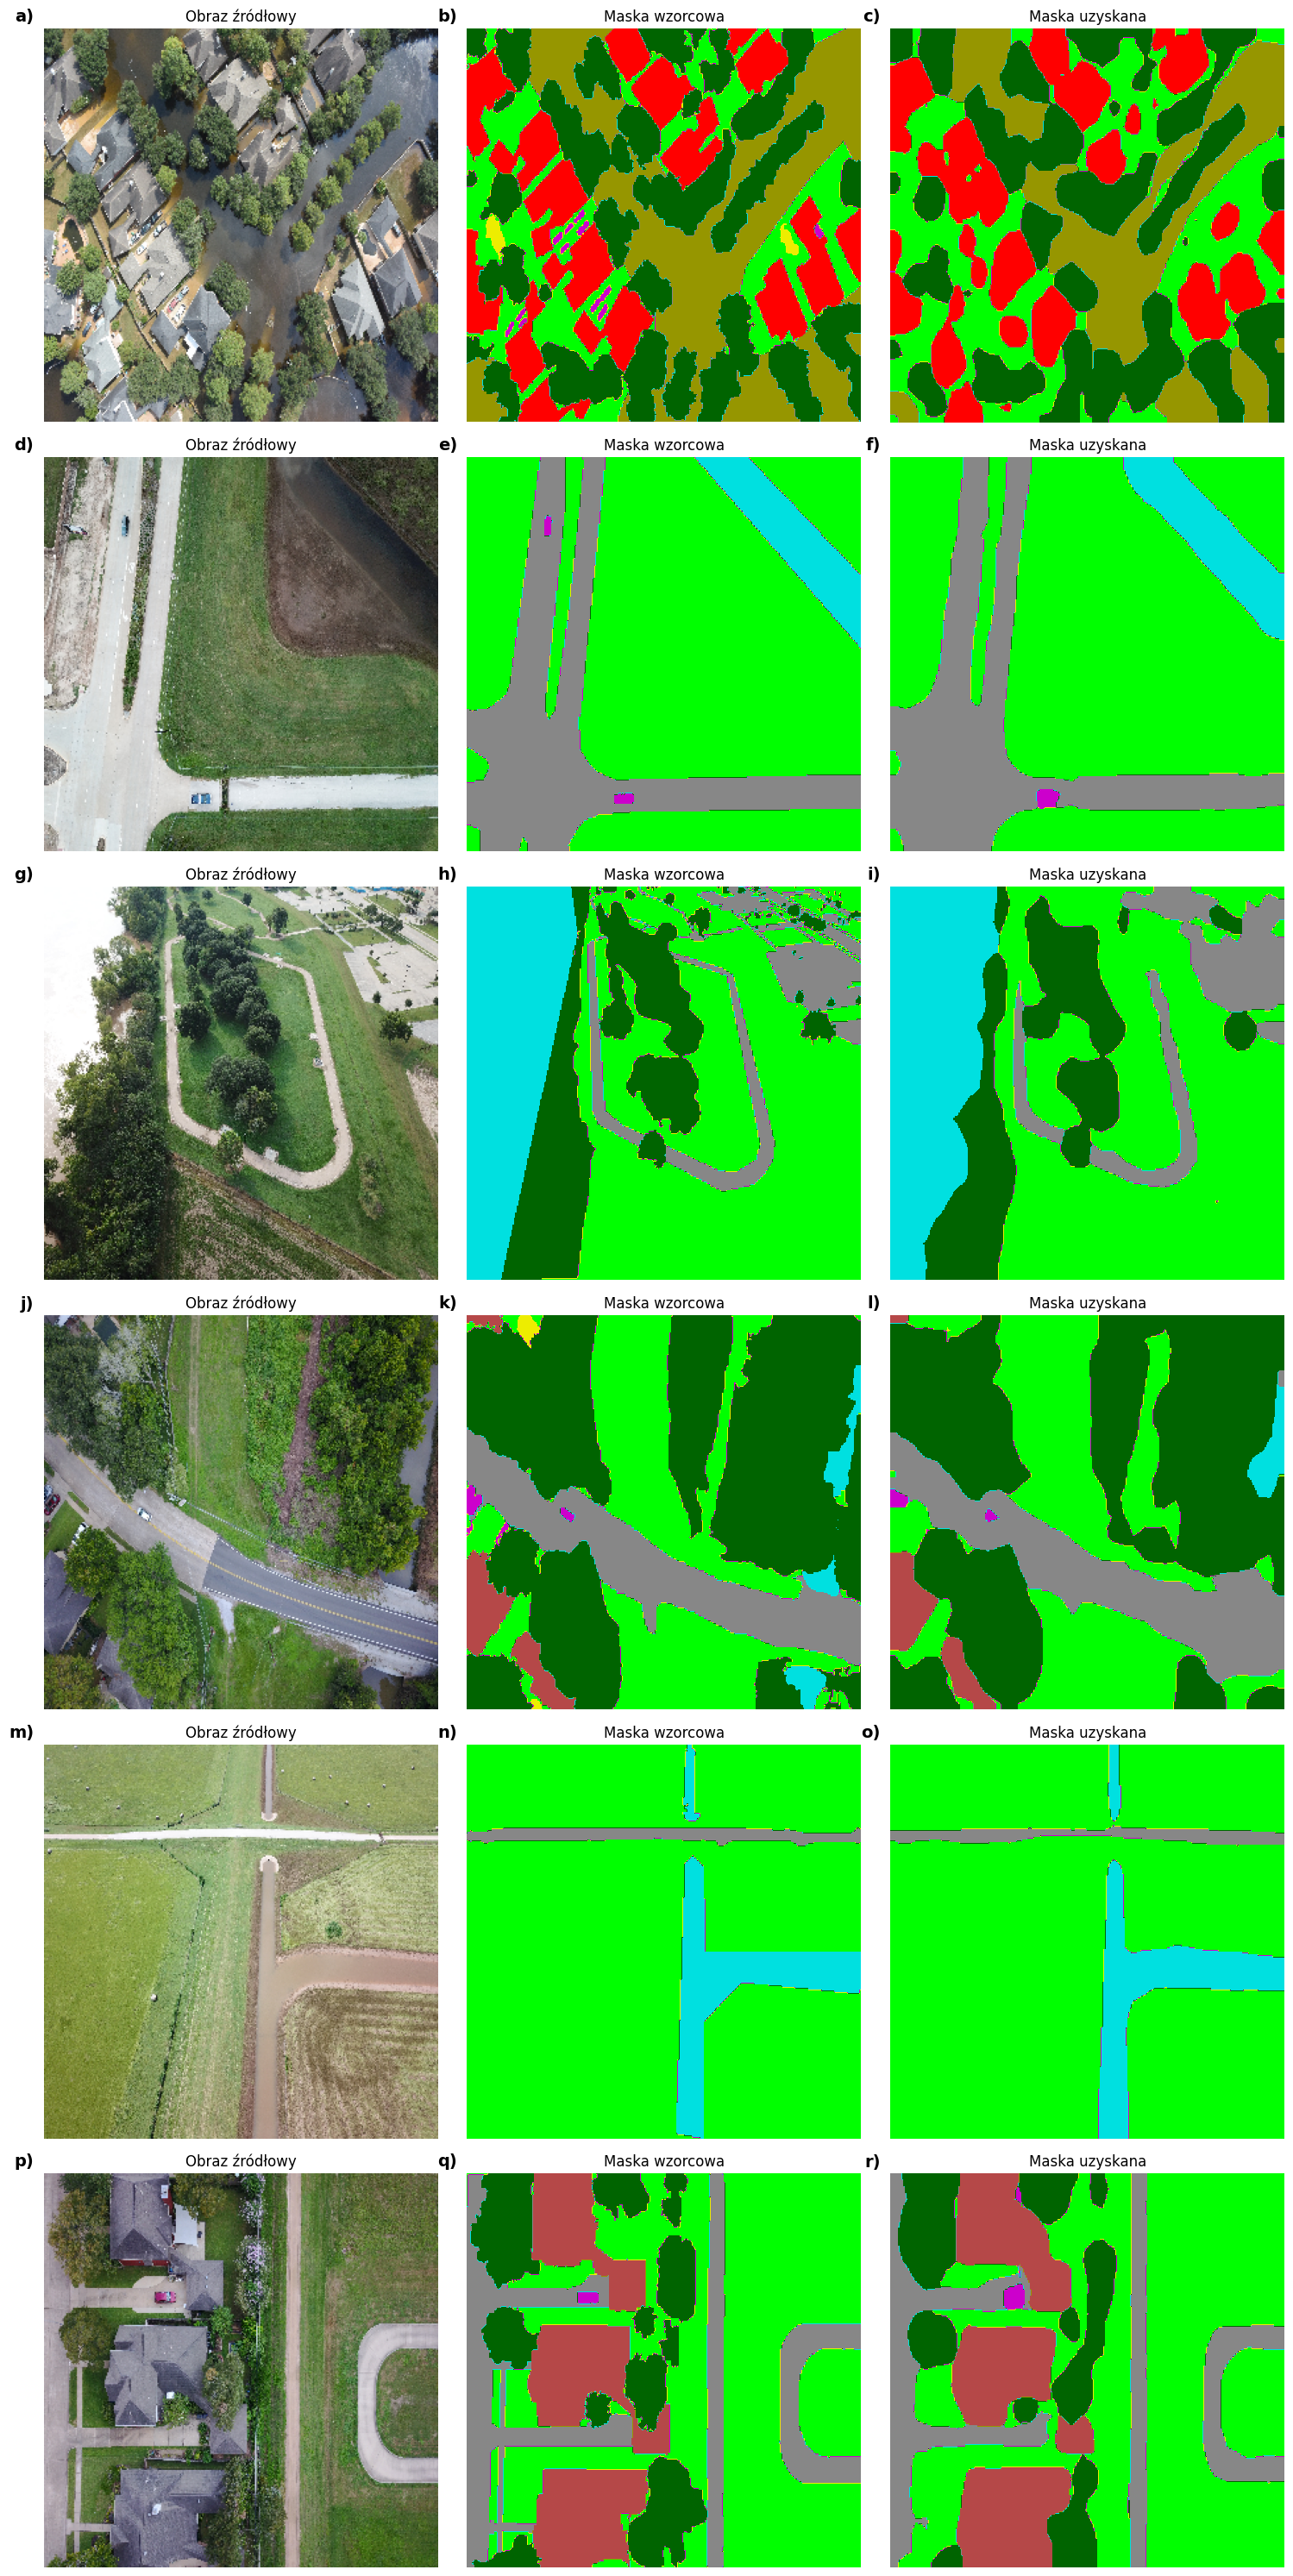

In [ ]:
from models.DeepLabV3 import DeepLabV3
from models.ENet import ENet
from models.UNet3plus import UNet3plus
from models.PSPNet import PSPNet
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
COLORMAP = [
    (0, 0, 0),
    (255, 0, 0),
    (181, 72, 72),
    (150, 150, 0),
    (135, 135, 135),
    (0, 224, 224),
    (0, 100, 0),
    (204, 0, 204),
    (237, 237, 0),
    (0, 255, 0)
]
normalized_colors = np.array(COLORMAP) / 255.0
cmap = ListedColormap(normalized_colors)
labels = list(string.ascii_lowercase)

model = DeepLabV3()
model_path = "seg_no_aug/segmentation_deeplab_ce.pth"
model.load_model(model_path)
model.move_to_device("cuda")
model.eval_mode()

img_size = (299, 299)
images = ["7320", "6336", "8478", "6561", "7069", "9060"] # used as inference examples
# images = ["8949", "9045", "9018", "9109", "10174", "9042"]
fig, axes = plt.subplots(6, 3, figsize=(15, 30))
for i, num in enumerate(images):
    image_path = f"../dataset/FloodNet_dataset/test/image/{num}.jpg"
    ground_truth_path = f"../dataset/FloodNet_dataset/test/label/{num}_lab.png"
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = seg_joint_transform(input_image)
    input_tensor = segmentation_image_tf(input_tensor)
    input_tensor = input_tensor.unsqueeze(0).to("cuda")

    gt_mask = Image.open(ground_truth_path)

    with torch.no_grad():
        outputs = model.forward(input_tensor)
        pred_mask = torch.argmax(outputs.squeeze(), dim=0).cpu().numpy()

    pred_mask = Image.fromarray(pred_mask.astype(np.uint8))
    pred_mask = np.array(pred_mask)
    idx = i * 3
    axes[i][0].imshow(input_image.resize(img_size, Image.NEAREST))
    axes[i][0].set_title("Obraz źródłowy")
    axes[i][0].axis('off')
    axes[i][0].text(-0.025, 1.05, f"{labels[idx+0]})", transform=axes[i][0].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

    # Ground truth mask
    axes[i][1].imshow(gt_mask.resize(img_size, Image.NEAREST), cmap=cmap, vmin=0, vmax=9)
    axes[i][1].set_title("Maska wzorcowa")
    axes[i][1].axis('off')
    axes[i][1].text(-0.025, 1.05, f"{labels[idx+1]})", transform=axes[i][1].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

    # Predicted mask
    axes[i][2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=9)
    axes[i][2].set_title("Maska uzyskana")
    axes[i][2].axis('off')
    axes[i][2].text(-0.025, 1.05, f"{labels[idx+2]})", transform=axes[i][2].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.savefig(f"difficults_{model_path.replace('/', '_').replace('.pth', '')}.png", dpi=300, bbox_inches='tight')
plt.show()